# Rodando os modelos com Cross Validation

In [17]:
# Bibliotecas de manipualção e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Classes dos modelo
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import EditedNearestNeighbours

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC


In [2]:
df_hepatite = pd.read_csv('HCV-Egy-Data.csv')

In [3]:
# dataset sem outliers
df_hepatite = pd.read_csv('HCV-Egy-Data-no-outlier.csv')

A remoção de outliers mostrou-se eficiente na performace do modelo aumentando em serca de 1% a acurácia.

In [4]:
df_hepatite.head()

,Unnamed: 0,Age,Gender,BMI,Fever,Nausea/Vomting,Headache,Diarrhea,FGba,Jaundice,...,ALT 36,ALT 48,ALT after 24 w,RNA Base,RNA 4,RNA 12,RNA EOT,RNA EF,BhG,Baselinehistological staging
0,1,46,1,29,1,2,2,1,2,2,...,57,123,44,40620,538635,637056,336804,31085,4,2
1,3,49,2,33,1,2,1,2,1,2,...,48,77,33,1041941,449939,585688,744463,582301,10,3
2,5,58,2,22,2,2,2,1,2,2,...,73,114,29,1157452,1086852,5,5,5,4,4
3,6,42,2,26,1,1,2,2,2,2,...,84,80,28,325694,1034008,275095,214566,635157,12,4
4,7,48,2,30,1,1,2,2,1,1,...,96,53,39,641129,72050,787295,370605,506296,12,3


### Seperação da váriável target do dataset

In [5]:
X = df_hepatite.drop(['BhG', 'Baselinehistological staging'], axis=1)
y = df_hepatite['Baselinehistological staging']

### Normalização dos dados

Com a normalização dos dados o modelo melhorou de predição almentou em um valor de 6% na sua acurácia.

In [6]:
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X)

In [7]:
#função que retorna um dicionário com os valores dos resultados
def model_results(model, X_train, y_train, X_test, y_test,results_dict_aux):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #medindo e armazenando acurácia, f1-score e auc-score no dicionário
    accuracy = model.score(X_test, y_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    AUC = roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo')
    CM = confusion_matrix(y_test, y_pred)

    results_dict_aux['accuracy'].append(accuracy)
    results_dict_aux['f1'].append(f1)
    results_dict_aux['auc'].append(AUC)
    results_dict_aux['cm'].append(CM)
    '''print(f"f1: {f1}\n")
    print(f"Accuracy: {accuracy}\n")
    print(f"CM: \n{CM} \n")'''
    print(f"AUC: %.6f" %(AUC))
    
    print("-----------------------CURVA ROC---------------------")
    visualizer = ROCAUC(model, encoder={1:"Class 1", 2:"Class 2", 3:"Class 3", 4:"Class 4"})

    visualizer.fit(X_train, y_train)        
    visualizer.score(X_test, y_test)        
    visualizer.show()                       
    #print("-----------------------------------------------------\n")
    return results_dict_aux

## Grid Search

Para cada modelo é implementada uma função do grid search. Para ser aplicada em cada um dos 10 conjuntos de treino do 10-fold.

**KNN**

In [8]:
def kNN_grid_search(X_train, y_train):
    #lista com números impares para o número de vizinhos do knn
    k_range = [impar for impar in range(1,32) if (impar%2)!=0]
    #listas com formas de considerar a ditância do vizinho
    weights = ['uniform', 'distance']
    #lista com formas de calcular as distâncias
    dist = ['euclidian','manhattan','chebyshev']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'n_neighbors': k_range,
        'weights': weights,
        'metric': dist
    }
    
    # defining parameter range
    grid = GridSearchCV(knn(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    k = grid.best_params_['n_neighbors']
    w = grid.best_params_['weights']
    m = grid.best_params_['metric']

    print("KNN")
    print(f"Melhores parâmetros - k:{k}, w:{w}, m:{m}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (k,w,m)

**Decision Tree**

In [9]:
def dt_grid_search(X_train, y_train):
    #
    max_depth_range = [x for x in range(1,32)]
    #listas com formas de medir a qualidade do 'split'
    criterion_list = ['gini', 'entropy']
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'max_depth': max_depth_range,
        'criterion': criterion_list,
    }
    # defining parameter range
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    md = grid.best_params_['max_depth']
    c = grid.best_params_['criterion']

    print("DT")
    print(f"Melhores parâmetros - md:{md}, c:{c}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")


    return (md,c)

**MLP**

In [10]:
def mlp_grid_search(X_train, y_train):
    # lista com o número de camadas
    hidden_layer_sizes_list = [(100,), (50, 15, 5), (100, 25, 10)]
    # listas das taxas de aprendizado inicial
    learning_rate_init_list = [0.05, 0.0001]
    # lista de estratégias
    solver_list = ['sgd', 'adam']
    # lista das funções de ativações
    activation_list = ['tanh', 'relu']
    # lista da forma da taxa de aprendizado
    learning_rate_lsit = ['constant', 'adaptive']
    # dicionário com parêmetros para o gridsearch
    param_grid = {
        'hidden_layer_sizes': hidden_layer_sizes_list,
        'activation': activation_list,
        'solver': solver_list,
        'learning_rate': learning_rate_lsit,
        'learning_rate_init': learning_rate_init_list,
    }
    # defining parameter range
    grid = GridSearchCV(MLPClassifier(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    # utilizando melhores parâmetros calculados pelo gridsearch
    hls = grid.best_params_['hidden_layer_sizes']
    a = grid.best_params_['activation']
    s = grid.best_params_['solver']
    lr = grid.best_params_['learning_rate']
    lri = grid.best_params_['learning_rate_init']

    print("MLP")
    print(f"Melhores parâmetros - hls:{hls}, a:{a}, s:{s}, lr:{lr}, lri:{lri}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (hls, a, s, lr, lri)

**SVM**

In [11]:
def svm_grid_search(X_train, y_train):
    #
    C_list = [0.1, 1, 10, 100]
    kernel_list = ['rbf','sigmoid'] #['linear', 'poly', 'rbf', 'sigmoid']
    gamma_list = [1, 0.1, 0.01, 0.001]
    #dicionário com parêmetros para o gridsearch
    param_grid = {
        'C': C_list,
        'kernel': kernel_list,
        'gamma': gamma_list
    }
    # defining parameter range
    grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
    # fitting the model for grid search
    grid.fit(X_train, y_train)

    #utilizando melhores parâmetros calculados pelo gridsearch
    c = grid.best_params_['C']
    k = grid.best_params_['kernel']
    g = grid.best_params_['gamma']

    print("SVM")
    print(f"Melhores parâmetros - C:{c}, k:{k}\n, g:{g}")
    print(f"Accuracy: %.6f" %(grid.best_score_))
    print("------------------------------------------------")

    return (c,k,g)

## 10-Fold

Com esse método são criados 10 datasets de treino e 10 datasets de test com uma divisão de 90% para treino e 10% para teste em cada divisão.

O conjunto de treino sera divido mais uma vez em treino e validação (isso é feito dendo da função `GridSearchCV` para que então seja aplicado o GridSearch e assim obtenha-se os melhores parâmetros. Por fim, tendo os melhores parâmetros, utiliza-se o conjunto de teste para que se possa avaliar os resultados.

Esses resultados são obtidos de cada fold e então se tira a média deles para obter-se a avaliação final de cada modelo.

In [12]:
#função que roda os modelos em cada uma das divisões do 10-fold
#e imprime a média e o desvio padrão dos resultados

def evaluate_model_with_kfold(kf):
    results_dict_models = {}
    # listas e dicionarios para salvar as métricas dos resultados de todas as interacoes
    
    results_dict_KNN = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_DT = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_MLP = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_SVM = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }
    results_dict_GNB = {
        'accuracy': [],
        'f1': [],
        'auc': [],
        'cm': []
    }

    
    for train, test in kf.split(X, y):
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]        
        
        #########################################################################
        # PCA - Principal Component Analysis
        # 
        pca = PCA(n_components = 0.95)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        #########################################################################
        #####################################################################
        # ENN - Edited Nearest Neighbors
        resampler = EditedNearestNeighbours(n_neighbors=5, sampling_strategy="auto", kind_sel="mode")
        X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_pca, y_train)
        #####################################################################
        
        #kNN
        k,w,m = kNN_grid_search(X_train_resampled, y_train_resampled)
        model = knn(n_neighbors=k, weights=w, metric=m)
        results_dict_KNN = model_results(model, X_train_resampled, y_train_resampled, X_test_pca, y_test, results_dict_KNN)

        #DT
        md,c = dt_grid_search(X_train_resampled, y_train_resampled)
        model = DecisionTreeClassifier(max_depth=md, criterion=c, random_state=199)
        results_dict_DT = model_results(model, X_train_resampled, y_train_resampled, X_test_pca, y_test, results_dict_DT)

        #MLP 
        hls, a, s, lr, lri = mlp_grid_search(X_train_resampled, y_train_resampled)
        model = MLPClassifier(
            hidden_layer_sizes=hls, 
            activation=a, 
            solver=s, 
            learning_rate=lr, 
            learning_rate_init=lri, 
            max_iter=2000, 
            tol=0.000001,
            random_state=199
        )
        results_dict_MLP = model_results(model, X_train_resampled, y_train_resampled, X_test_pca, y_test, results_dict_MLP)
         
        #GNB 
        model = GaussianNB()
        results_dict_models['GNB'] = model_results(model, X_train_resampled, y_train_resampled, X_test_pca, y_test, results_dict_GNB)

        #SVM
        c, k, g = svm_grid_search(X_train_resampled, y_train_resampled)
        model = SVC(C=c, kernel=k, gamma=g, probability=True, random_state=199)
        results_dict_SVM = model_results(model, X_train_resampled, y_train_resampled, X_test_pca, y_test, results_dict_SVM)

    results_dict_models['KNN'] = results_dict_KNN
    results_dict_models['DT'] = results_dict_DT
    results_dict_models['MLP'] = results_dict_MLP
    results_dict_models['GNB'] = results_dict_GNB
    results_dict_models['SVM'] = results_dict_SVM
    
    # a cada interação calcula a média e o desvio padrão da 
    # acurácia, f1-score, auc-scor e matriz de confusão de cada modelo
    for model_key in results_dict_models.keys():
        accuracies = np.array(results_dict_models[model_key]['accuracy'])
        f1 = np.array(results_dict_models[model_key]['f1'])
        auc = np.array(results_dict_models[model_key]['auc'])
        conf_matrix = np.array(results_dict_models[model_key]['cm'])

        print(f"\t{model_key}")
        print("Acurácia média (desvio): %.6f +- (%.6f)" %(accuracies.mean(), accuracies.std()))
        print("F1-score média (desvio): %.6f +- (%.6f)" %(f1.mean(), f1.std()))
        print("AUC média (desvio): %.6f +- (%.6f)\n" %(auc.mean(), auc.std()))
        print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}")
        # print(f"Matriz de Confusão:  \n{sum(conf_matrix)*0.1}\n")
    print("------------------------------------------------")

In [13]:
import warnings

KNN
Melhores parâmetros - k:3, w:uniform, m:manhattan
Accuracy: 0.586871
------------------------------------------------
AUC: 0.532120
-----------------------CURVA ROC---------------------


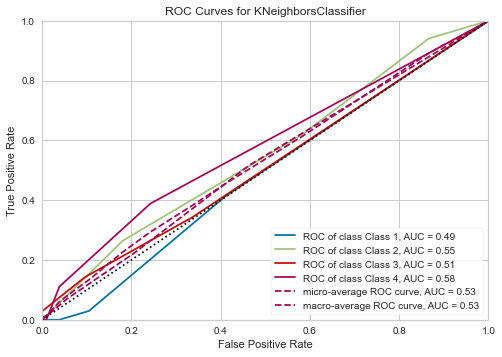

DT
Melhores parâmetros - md:3, c:entropy
Accuracy: 0.546588
------------------------------------------------
AUC: 0.475424
-----------------------CURVA ROC---------------------


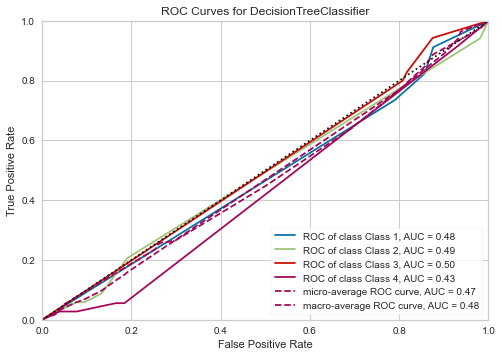

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.542965
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


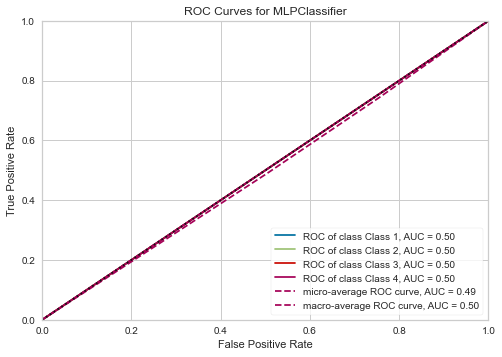

AUC: 0.492889
-----------------------CURVA ROC---------------------


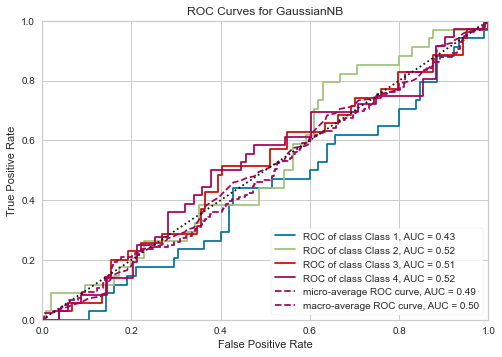

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.542965
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


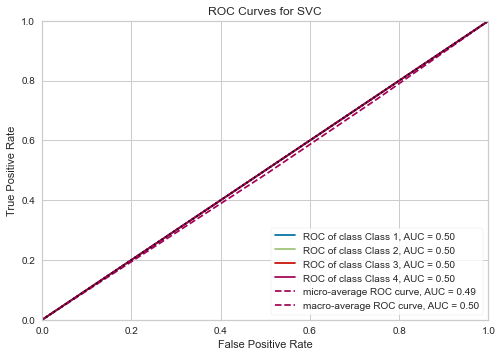

KNN
Melhores parâmetros - k:1, w:uniform, m:manhattan
Accuracy: 0.582437
------------------------------------------------
AUC: 0.520133
-----------------------CURVA ROC---------------------


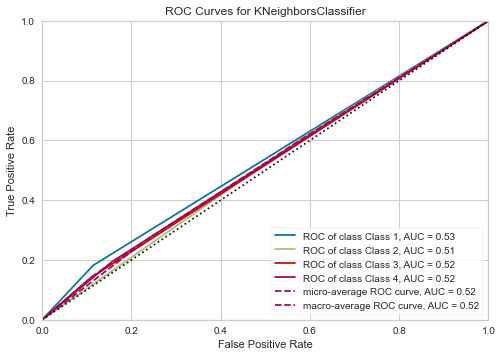

DT
Melhores parâmetros - md:1, c:gini
Accuracy: 0.534050
------------------------------------------------
AUC: 0.489588
-----------------------CURVA ROC---------------------


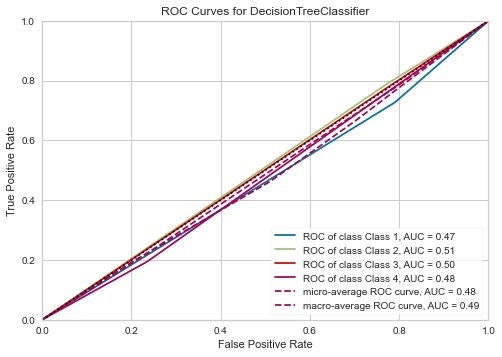

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.534050
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


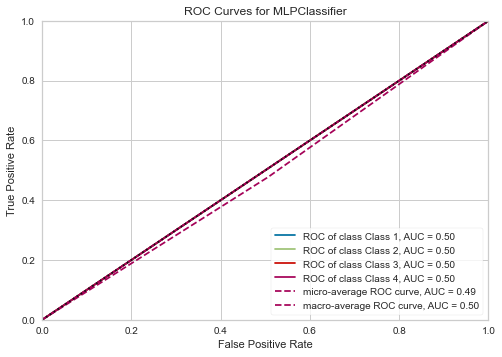

AUC: 0.548669
-----------------------CURVA ROC---------------------


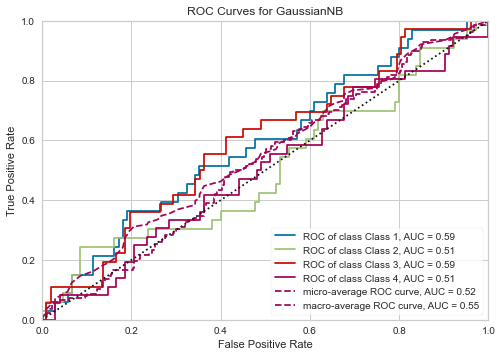

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.534050
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


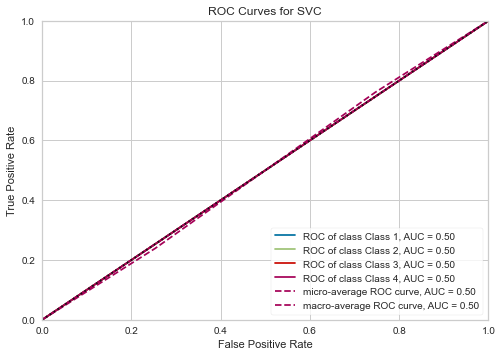

KNN
Melhores parâmetros - k:17, w:distance, m:manhattan
Accuracy: 0.589595
------------------------------------------------
AUC: 0.554110
-----------------------CURVA ROC---------------------


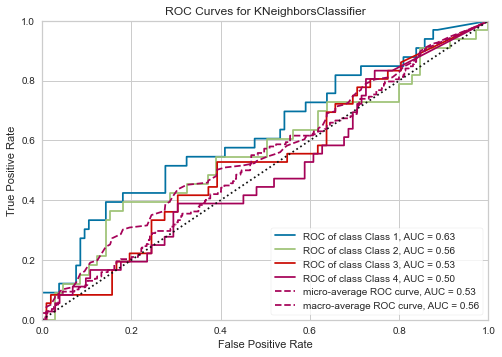

DT
Melhores parâmetros - md:1, c:entropy
Accuracy: 0.574181
------------------------------------------------
AUC: 0.476669
-----------------------CURVA ROC---------------------


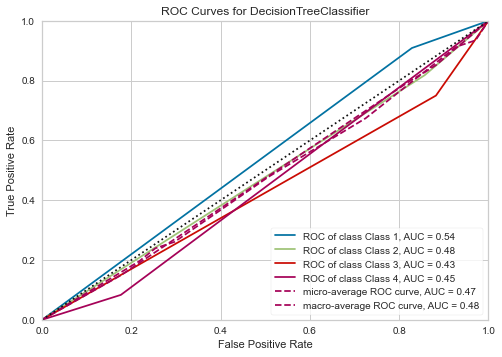

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.574181
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


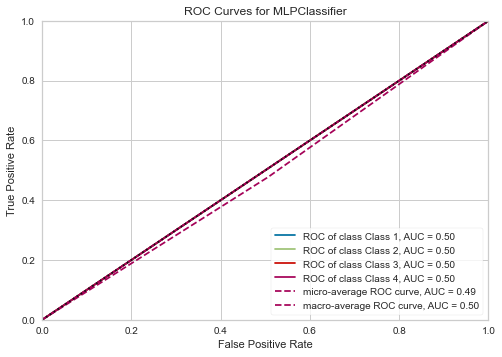

AUC: 0.532349
-----------------------CURVA ROC---------------------


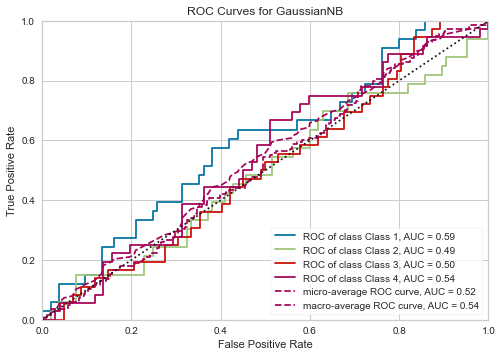

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.574181
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


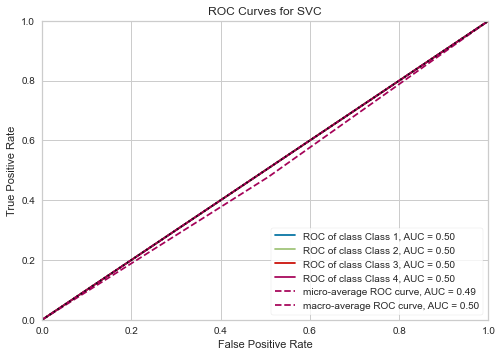

KNN
Melhores parâmetros - k:17, w:distance, m:manhattan
Accuracy: 0.577778
------------------------------------------------
AUC: 0.521867
-----------------------CURVA ROC---------------------


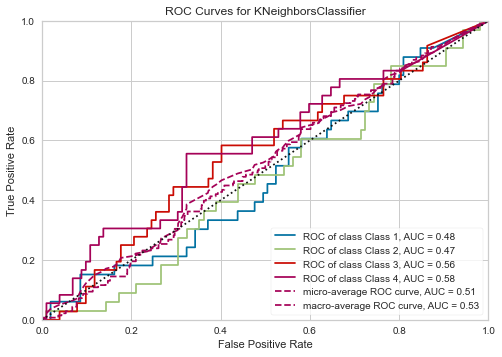

DT
Melhores parâmetros - md:5, c:gini
Accuracy: 0.544444
------------------------------------------------
AUC: 0.445237
-----------------------CURVA ROC---------------------


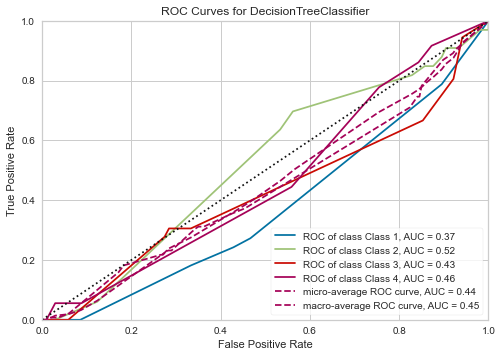

MLP
Melhores parâmetros - hls:(50, 15, 5), a:tanh, s:adam, lr:constant, lri:0.05
Accuracy: 0.562963
------------------------------------------------
AUC: 0.528064
-----------------------CURVA ROC---------------------


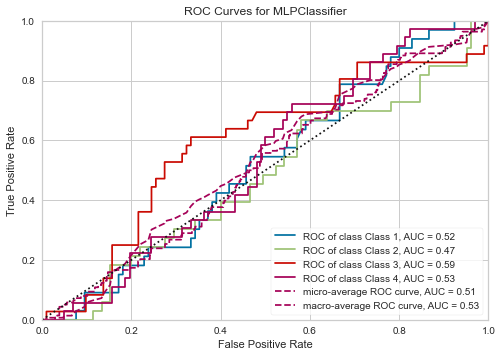

AUC: 0.567471
-----------------------CURVA ROC---------------------


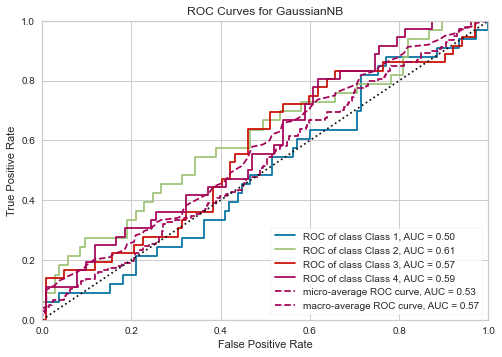

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.551852
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


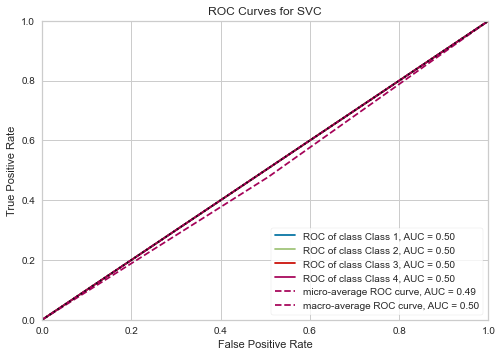

KNN
Melhores parâmetros - k:3, w:distance, m:manhattan
Accuracy: 0.598153
------------------------------------------------
AUC: 0.470938
-----------------------CURVA ROC---------------------


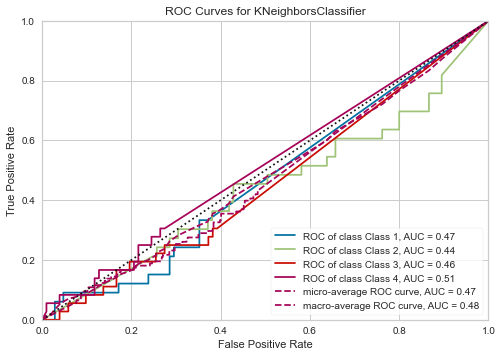

DT
Melhores parâmetros - md:2, c:entropy
Accuracy: 0.566031
------------------------------------------------
AUC: 0.468800
-----------------------CURVA ROC---------------------


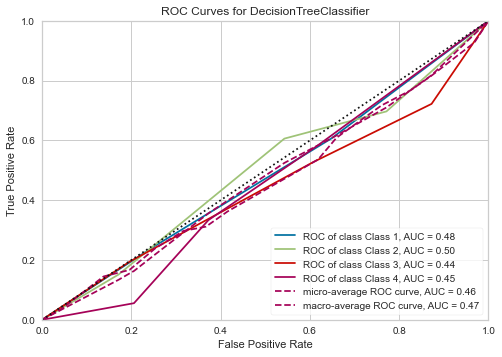

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.562265
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


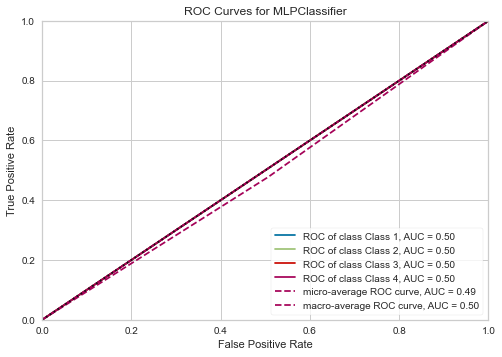

AUC: 0.438598
-----------------------CURVA ROC---------------------


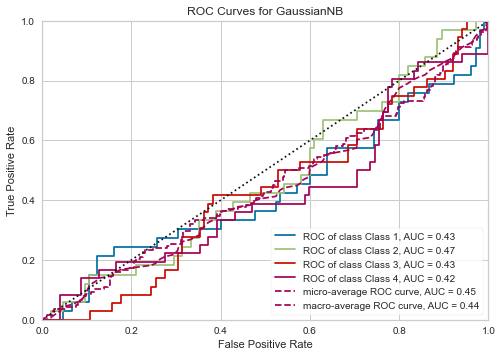

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.562265
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


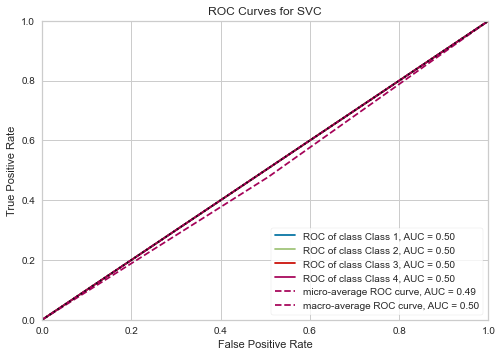

KNN
Melhores parâmetros - k:1, w:uniform, m:manhattan
Accuracy: 0.654186
------------------------------------------------
AUC: 0.496116
-----------------------CURVA ROC---------------------


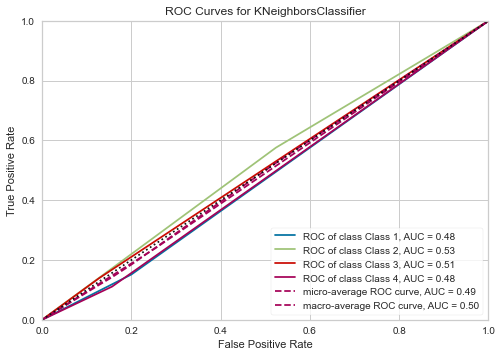

DT
Melhores parâmetros - md:2, c:entropy
Accuracy: 0.558889
------------------------------------------------
AUC: 0.518375
-----------------------CURVA ROC---------------------


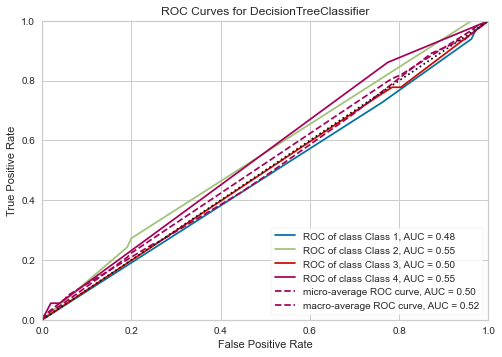

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.557017
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


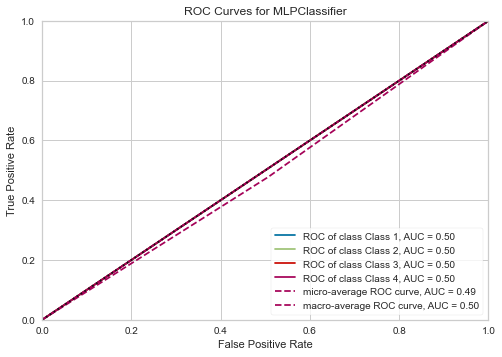

AUC: 0.490433
-----------------------CURVA ROC---------------------


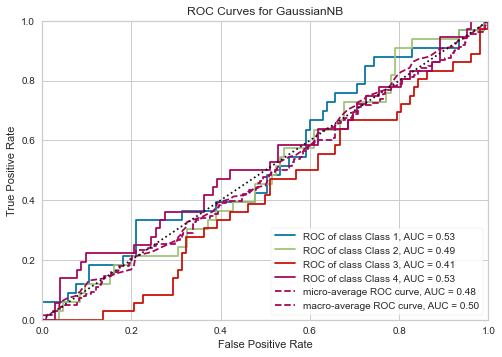

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.557017
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


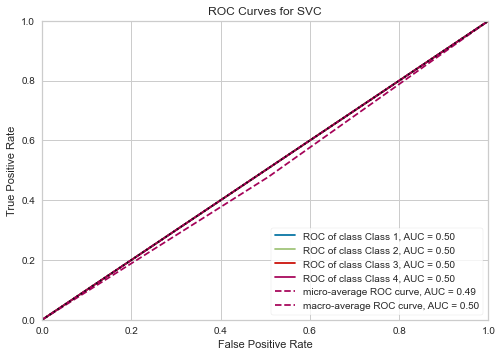

KNN
Melhores parâmetros - k:7, w:distance, m:manhattan
Accuracy: 0.614698
------------------------------------------------
AUC: 0.517181
-----------------------CURVA ROC---------------------


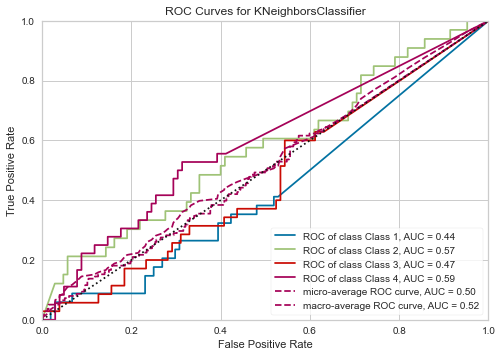

DT
Melhores parâmetros - md:1, c:gini
Accuracy: 0.546965
------------------------------------------------
AUC: 0.529417
-----------------------CURVA ROC---------------------


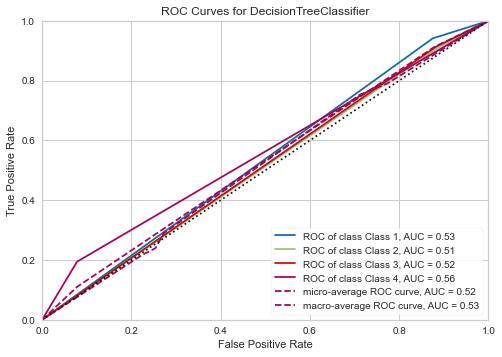

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.560147
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


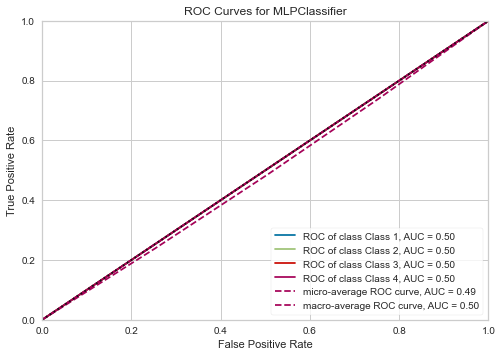

AUC: 0.487658
-----------------------CURVA ROC---------------------


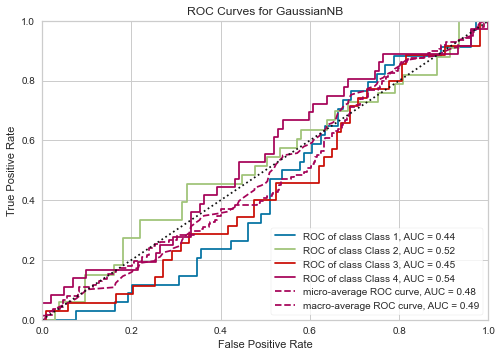

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.560147
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


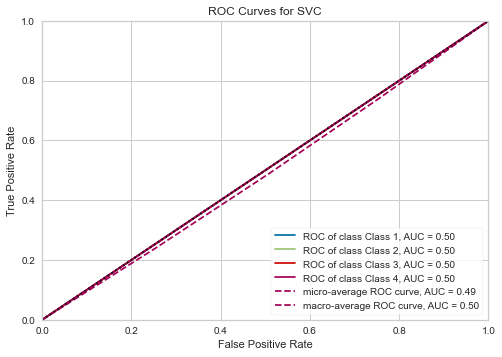

KNN
Melhores parâmetros - k:1, w:uniform, m:manhattan
Accuracy: 0.588342
------------------------------------------------
AUC: 0.465834
-----------------------CURVA ROC---------------------


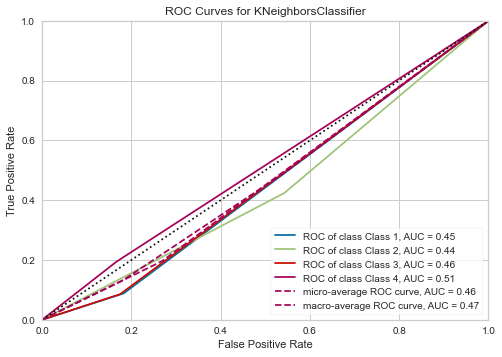

DT
Melhores parâmetros - md:1, c:gini
Accuracy: 0.542805
------------------------------------------------
AUC: 0.494681
-----------------------CURVA ROC---------------------


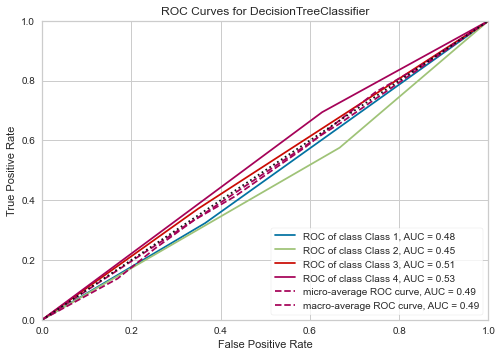

MLP
Melhores parâmetros - hls:(50, 15, 5), a:tanh, s:adam, lr:adaptive, lri:0.05
Accuracy: 0.544627
------------------------------------------------
AUC: 0.520481
-----------------------CURVA ROC---------------------


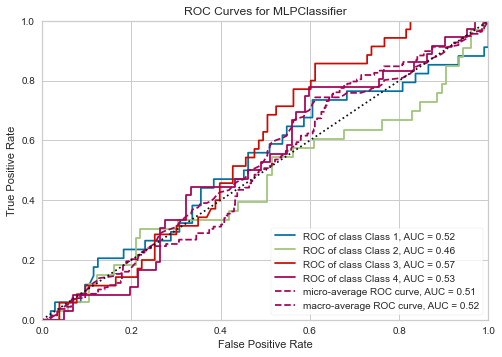

AUC: 0.497770
-----------------------CURVA ROC---------------------


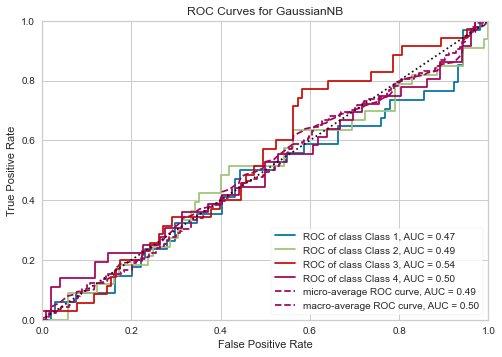

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.542805
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


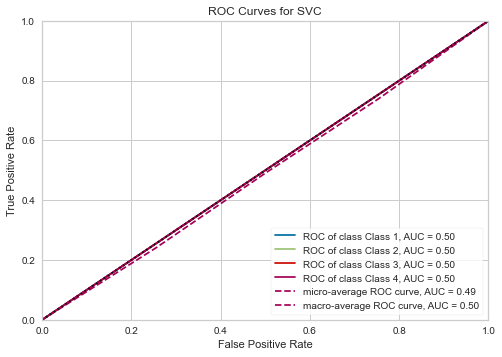

KNN
Melhores parâmetros - k:3, w:distance, m:manhattan
Accuracy: 0.621263
------------------------------------------------
AUC: 0.459082
-----------------------CURVA ROC---------------------


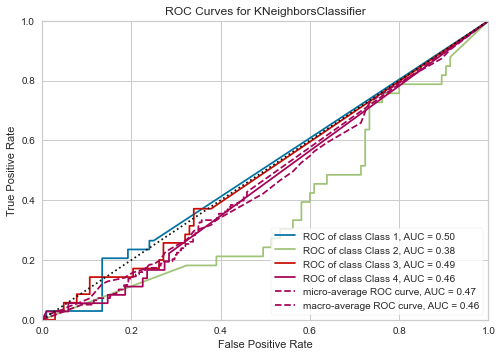

DT
Melhores parâmetros - md:2, c:entropy
Accuracy: 0.557833
------------------------------------------------
AUC: 0.519130
-----------------------CURVA ROC---------------------


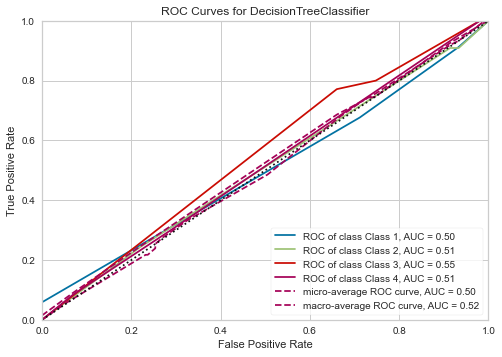

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.555981
------------------------------------------------
AUC: 0.497548
-----------------------CURVA ROC---------------------


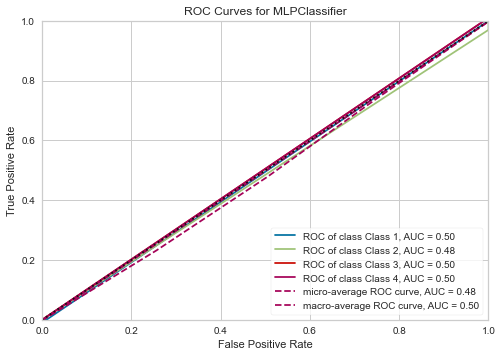

AUC: 0.530534
-----------------------CURVA ROC---------------------


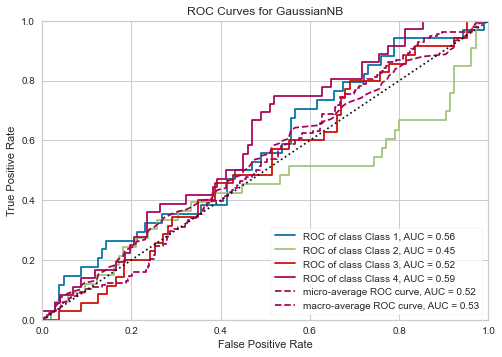

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.555981
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


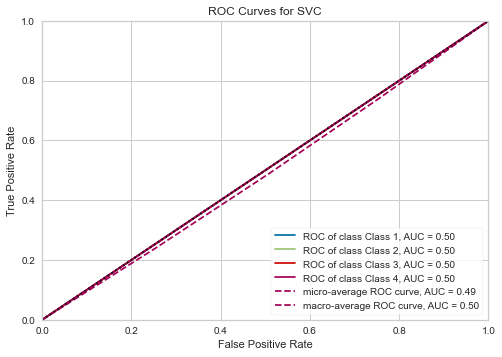

KNN
Melhores parâmetros - k:13, w:distance, m:chebyshev
Accuracy: 0.603749
------------------------------------------------
AUC: 0.514565
-----------------------CURVA ROC---------------------


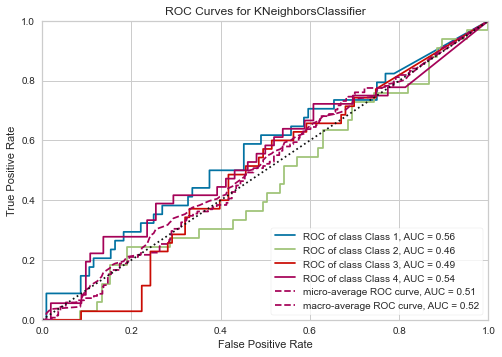

DT
Melhores parâmetros - md:1, c:entropy
Accuracy: 0.562265
------------------------------------------------
AUC: 0.546803
-----------------------CURVA ROC---------------------


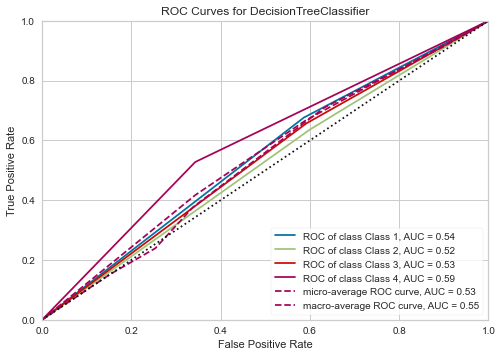

MLP
Melhores parâmetros - hls:(50, 15, 5), a:relu, s:sgd, lr:constant, lri:0.05
Accuracy: 0.562265
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


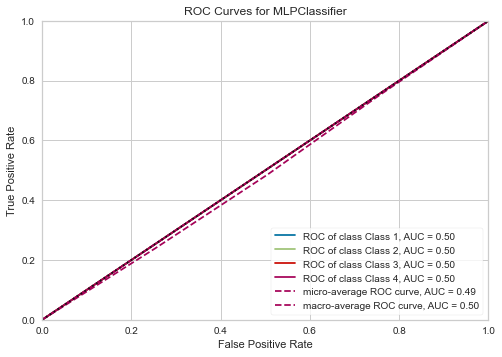

AUC: 0.523728
-----------------------CURVA ROC---------------------


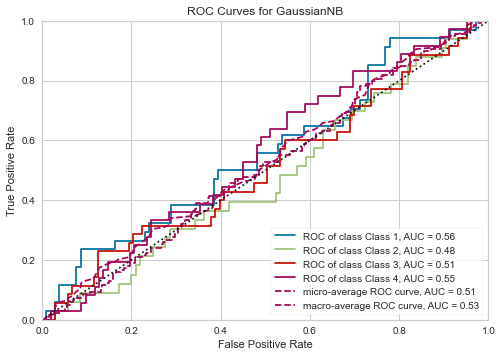

SVM
Melhores parâmetros - C:0.1, k:rbf
, g:1
Accuracy: 0.562265
------------------------------------------------
AUC: 0.500000
-----------------------CURVA ROC---------------------


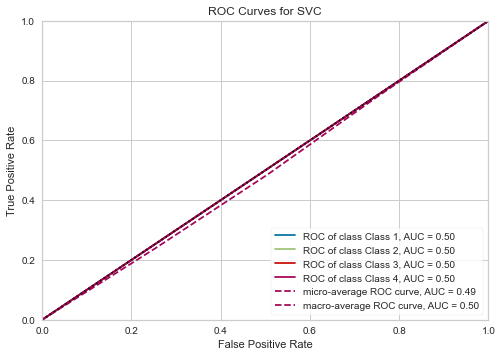

	GNB
Acurácia média (desvio): 0.238229 +- (0.006648)
F1-score média (desvio): 0.097445 +- (0.006207)
AUC média (desvio): 0.511010 +- (0.035100)

Matriz de Confusão:  
[[ 0.3 33.   0.1  0.1]
 [ 0.3 32.5  0.1  0.2]
 [ 0.3 35.1  0.   0.1]
 [ 0.2 35.5  0.2  0.1]]
	KNN
Acurácia média (desvio): 0.238943 +- (0.029922)
F1-score média (desvio): 0.189904 +- (0.031685)
AUC média (desvio): 0.505195 +- (0.029634)

Matriz de Confusão:  
[[ 3.4 22.7  4.3  3.1]
 [ 4.  22.2  3.7  3.2]
 [ 4.7 24.6  3.2  3. ]
 [ 3.9 24.7  3.2  4.2]]
	DT
Acurácia média (desvio): 0.238958 +- (0.006502)
F1-score média (desvio): 0.098831 +- (0.010564)
AUC média (desvio): 0.496412 +- (0.029813)

Matriz de Confusão:  
[[ 0.  32.8  0.5  0.2]
 [ 0.2 32.5  0.3  0.1]
 [ 0.5 34.7  0.1  0.2]
 [ 0.  35.5  0.1  0.4]]
	MLP
Acurácia média (desvio): 0.239678 +- (0.003633)
F1-score média (desvio): 0.104553 +- (0.036091)
AUC média (desvio): 0.504609 +- (0.010003)

Matriz de Confusão:  
[[ 0.7 32.3  0.2  0.3]
 [ 0.5 31.7  0.4  0.5]
 [ 0.9 3

In [14]:
#%%time
#ignorando warnings
warnings.filterwarnings('ignore')

evaluate_model_with_kfold(StratifiedKFold(n_splits=10, shuffle=True, random_state=199))

## Plotando Matrizes de Confusão

In [18]:
def mc_plot(df,model):
    df.rename(columns={0:1, 1:2, 2:3, 3:4}, index={0:1, 1:2, 2:3, 3:4}, inplace=True)
    #fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(
        df, 
        cmap="Blues", 
        annot=True, 
        fmt="0.1f",
        annot_kws={
            'fontsize': 11,
            'fontweight': 'bold'
        },
        linewidth=0.8,
        linecolor='gray',
        square=True
   ).set_title(model)

In [19]:
knn_conf_mtx = np.array([[ 3.4, 22.7,  4.3,  3.1],
 [ 4.,  22.2,  3.7,  3.2],
 [ 4.7, 24.6,  3.2,  3. ],
 [ 3.9, 24.7,  3.2,  4.2]])

dt_conf_mtx = np.array([[ 0.,  32.8,  0.5,  0.2],
 [ 0.2, 32.5,  0.3,  0.1],
 [ 0.5, 34.7,  0.1,  0.2],
 [ 0.,  35.5,  0.1,  0.4]])

gnb_conf_mtx = np.array([[ 0.3, 33.,   0.1,  0.1],
 [ 0.3, 32.5,  0.1,  0.2],
 [ 0.3, 35.1,  0.,   0.1],
 [ 0.2, 35.5,  0.2,  0.1]])
mlp_conf_mtx = np.array([[ 0.7, 32.3,  0.2,  0.3],
 [ 0.5, 31.7,  0.4,  0.5],
 [ 0.9, 33.8,  0.4,  0.4],
 [ 0.4, 34.7,  0.6,  0.3]])

svm_conf_mtx = np.array([[ 0.,  33.5,  0.,   0. ],
 [ 0.,  33.1,  0.,   0. ],
 [ 0.,  35.5,  0.,   0. ],
 [ 0.,  36.,   0.,   0. ]])

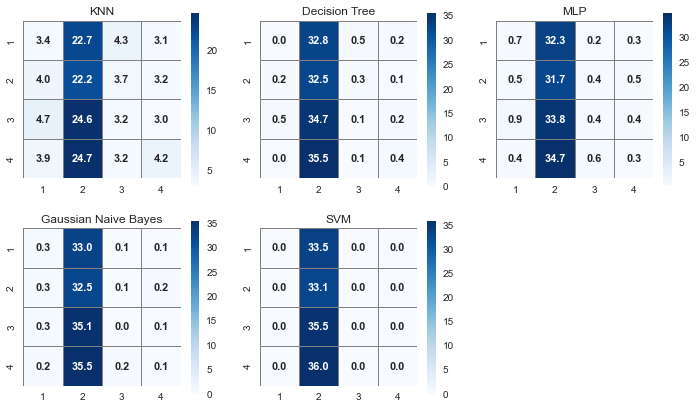

In [20]:
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
mc_plot(pd.DataFrame(knn_conf_mtx),'KNN')

plt.subplot(2,3,2)
mc_plot(pd.DataFrame(dt_conf_mtx),'Decision Tree')

plt.subplot(2,3,3)
mc_plot(pd.DataFrame(mlp_conf_mtx),'MLP')

plt.subplot(2,3,4)
mc_plot(pd.DataFrame(gnb_conf_mtx),'Gaussian Naive Bayes')

plt.subplot(2,3,5)
mc_plot(pd.DataFrame(svm_conf_mtx),'SVM')